#MediSeg

This projects uses a deep learning model created using TensorFlow and Natural Language Processing (NLP) techniques to segment the abstract of a medical research paper into sections such as objevtives, methods, background and conclusions.

####Tensorboard Link for modelling experiments comparisions https://tensorboard.dev/experiment/ulX1DpmrSjmfpJmV0Iy8rw/#scalars&runSelectionState=eyJNb2RlbF80X3Rva2VuX2NoYXJfdG9rZW4vMjAyMzA3MTAtMDg0OTA1L3RyYWluIjp0cnVlLCJNb2RlbF81X3Rva2VuX2NoYXJfdG9rZW5fcG9zX2VtYmVkZGluZ3MvMjAyMzA3MTAtMTEwOTM5L3ZhbGlkYXRpb24iOmZhbHNlLCJNb2RlbF81X3Rva2VuX2NoYXJfdG9rZW5fcG9zX2VtYmVkZGluZ3MvMjAyMzA3MTAtMTEwOTM5L3RyYWluIjpmYWxzZSwiTW9kZWxfNV90b2tlbl9jaGFyX3Rva2VuX3Bvc19lbWJlZGRpbmdzLzIwMjMwNzEwLTExMDg0My90cmFpbiI6ZmFsc2UsIk1vZGVsXzVfdG9rZW5fY2hhcl90b2tlbl9wb3NfZW1iZWRkaW5ncy8yMDIzMDcxMC0xMTA3MDAvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzVfdG9rZW5fY2hhcl90b2tlbl9wb3NfZW1iZWRkaW5ncy8yMDIzMDcxMC0xMTA3MDAvdHJhaW4iOmZhbHNlfQ%3D%3D

##Fetching the data

In [ ]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-07-10 08:44:20.324398


In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9db1827b-2b2c-72e3-7f31-3803f4937922)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.98 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Visualizing the data

In [ ]:
#create a function to read lines in colab
def get_lines(filename):
  """
  Read file names and returns the lines as a list

  Args:
  filename: a string containing the target filepath

  Returns:
  A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

##Preprocessing the data

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Return a list of dictionaries with abstract line data

  Takes in the filename, reads it and sorts the data
  line by line returning a set of target label,the
  text of the sentence and the toal number of lines in ana abstract.

  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): #Checking for ID lines
      abstract_id = line
      abstract_lines = ""      #Resetting the string if the line is a new line
    elif line.isspace():       #checking if the line is a new line
      abstract_line_split = abstract_lines.splitlines() #splitting the abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 629 ms, sys: 91.3 ms, total: 720 ms
Wall time: 1.72 s


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

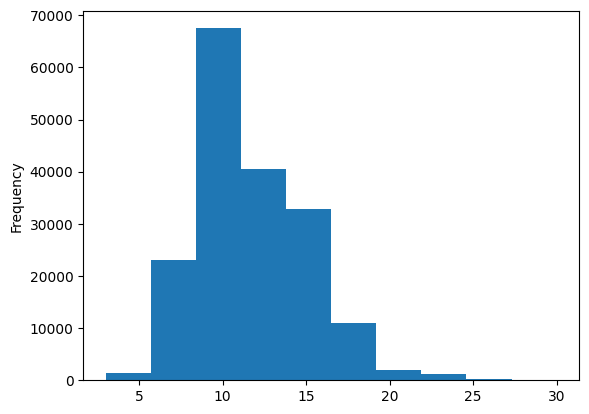

In [ ]:
train_df.total_lines.plot.hist();

##Formatting the data into sentences and labels

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Targets are in the form of text thus label encoading them so that we can easily feed it into our model

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0 : Baselimodel using the inbuilt sckikit learn model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Creating the pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fitting the model to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-07-10 13:30:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-10 13:30:45 (90.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Preparing the data for deep sequencing models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#How long is each sentence on an average

sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_len = np.mean(sentence_len)
avg_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

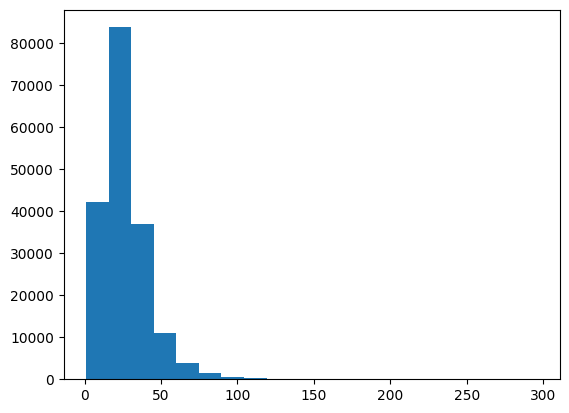

In [ ]:
#Checking the distribution
import matplotlib.pyplot as plt
plt.hist(sentence_len, bins=20)

##Creation of the text vectorizer layer

In [ ]:
#finding the length of the sentences belonging to atleast 95 percentile of the length of sentences
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len

55

In [ ]:
#maximum sequence length in the training set
max(sentence_len)

296

In [ ]:
#Text Vectorizer creation(obtained from the research paper from which the data is taken)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                 output_sequence_length = 55)##length of the sentences belonging to 95% of the sentences in the dataset

In [ ]:
#adapting the text_vectorizer to the training dataset and not the testing data as it may cause data leakage before training
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
lvrs may therefore have beneficial effects on cardiovascular outcomes .

Length of text: 10

Vectorized text:
[[12559    91   709    99   748    71    18   323    75     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

##Creation of the embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim = len(rct_20k_text_vocab), #length of the vocabulary
                       output_dim = 128, #multiple of 8
                       mask_zero = True) #increase efficiency of the computations by ignoring/masking empty or 0 values

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
lvrs may therefore have beneficial effects on cardiovascular outcomes .

Sentence after vectorization (before embedding):
[[12559    91   709    99   748    71    18   323    75     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00339754  0.03346366  0.04785402 ...  0.03741065  0.0480579
    0.04104377]
  [-0.03199033 -0.04816348 -0.03806491 ... -0.04492659  0.04949981
   -0.03227784]
  [-0.01278529 -0.0131816  -0.03588244 ...  0.04903135  0.01657328
    0.03021559]
  ...
  [ 0.01078918 -0.01428034 -0.03456051 ...  0.03633607 -0.01524425
    0.04993767]
  [ 0.01078918 -0.01428034 -0.03456051 ...  0.03633607 -0.01524425
    0.04993767]
  [ 0.01078918 -0.01428034 -0.03456051 ...  0.03633607 -0.

##Creating fastloading dataset using tensorflow.data API

In [ ]:
#Turning the dataset into a tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
#Take the tensorflow dataset and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Model : 1 CNN model

In [ ]:
from helper_functions import create_tensorboard_callback

In [ ]:
SAVE_DIR = "model_logs"

In [ ]:
from keras.api._v2.keras import activations
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D
inputs = Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf.keras.layers.Activation('relu')(x)
x = Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation = "softmax" , name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
#model compilation
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 activation (Activation)     (None, 55, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, "Model_1_CNN")]) # only validate on 10% of batches

Saving TensorBoard log files to: model_logs/Model_1_CNN/20230710-133115
Epoch 1/3
562/562 [==============================] - 43s 58ms/step - loss: 0.9509 - accuracy: 0.6297 - val_loss: 0.6568 - val_accuracy: 0.7566
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6201 - accuracy: 0.7721 - val_loss: 0.5701 - val_accuracy: 0.7872
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.5694 - accuracy: 0.7895 - val_loss: 0.5368 - val_accuracy: 0.8019


In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5411 - accuracy: 0.8009


[0.5411087870597839, 0.8008738160133362]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs


945/945 [==============================] - 2s 2ms/step


array([[4.8814216e-01, 1.7090069e-01, 5.6441417e-03, 3.3237153e-01,
        2.9414673e-03],
       [2.5409785e-01, 6.3074690e-01, 1.1037731e-03, 1.1173623e-01,
        2.3152113e-03],
       [1.3945153e-01, 1.1472520e-02, 2.9367842e-03, 8.4589672e-01,
        2.4240601e-04],
       ...,
       [3.0264317e-04, 2.6031451e-03, 2.4363259e-02, 3.7899512e-04,
        9.7235197e-01],
       [1.9720620e-02, 3.7948748e-01, 4.3171681e-02, 1.4158368e-02,
        5.4346180e-01],
       [1.3822569e-01, 8.0783010e-01, 1.8031823e-02, 1.5677469e-02,
        2.0234909e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.08738249702105,
 'precision': 0.7983781823835364,
 'recall': 0.8008738249702105,
 'f1': 0.7984620742639094}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Model 2 : using the tensorflow hub pretrained model

In [ ]:
import tensorflow_hub as hub
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable = False, name = "USE")

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = embed(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
history_2 = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)),
            callbacks = [create_tensorboard_callback(SAVE_DIR, "Model_2_CNN_USE")])

Saving TensorBoard log files to: model_logs/Model_2_CNN_USE/20230710-133305
Epoch 1/3
562/562 [==============================] - 12s 14ms/step - loss: 0.9163 - accuracy: 0.6475 - val_loss: 0.7958 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7687 - accuracy: 0.7017 - val_loss: 0.7540 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7515 - accuracy: 0.7129 - val_loss: 0.7389 - val_accuracy: 0.7144


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7417 - accuracy: 0.7135


[0.7417012453079224, 0.713458240032196]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[0.44576442, 0.33913174, 0.00240581, 0.20478831, 0.00790966],
       [0.35311064, 0.48050597, 0.00298427, 0.16027771, 0.0031213 ],
       [0.25050023, 0.15339705, 0.01596025, 0.5420686 , 0.03807389],
       ...,
       [0.00208888, 0.00610825, 0.06095154, 0.00094182, 0.9299095 ],
       [0.00318165, 0.0481795 , 0.20987825, 0.00129867, 0.737462  ],
       [0.15584633, 0.2603319 , 0.51244307, 0.00639483, 0.06498392]],
      dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.34582285184695,
 'precision': 0.7140266746910877,
 'recall': 0.7134582285184695,
 'f1': 0.7106520500944732}

##Model 3 : character level embeddings

In [ ]:
#Creating a function to spit the sentences to character
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
#Whats the averag elength of character
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

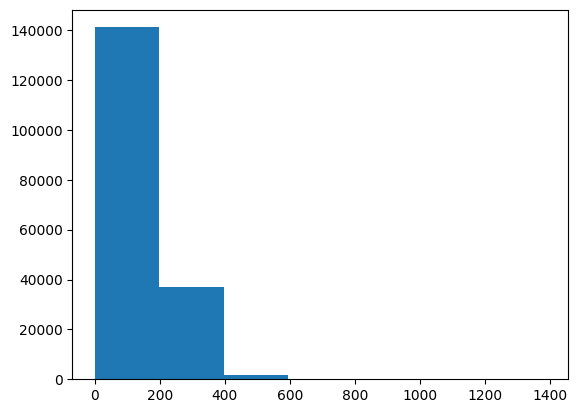

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p a t i e n t s   a n d   r e s e a r c h e r s   a s s e s s i n g   o u t c o m e   v a r i a b l e s   w e r e   b l i n d e d   t o   t h e   a s s i g n e d   s t u d y   g r o u p   .

Length of chars: 82

Vectorized chars:
[[14  5  3  4  2  6  3  9  5  6 10  8  2  9  2  5  8 11 13  2  8  9  5  9
   9  2  9  9  4  6 18  7 16  3 11  7 15  2 21  5  8  4  5 22 12  2  9 20
   2  8  2 22 12  4  6 10  2 10  3  7  3 13  2  5  9  9  4 18  6  2 10  9
   3 16 10 19 18  8  7 16 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 

In [ ]:
#creating a character level embedding layer
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero=False,
                              name="char_embed")
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p a t i e n t s   a n d   r e s e a r c h e r s   a s s e s s i n g   o u t c o m e   v a r i a b l e s   w e r e   b l i n d e d   t o   t h e   a s s i g n e d   s t u d y   g r o u p   .

Embedded chars (after vectorization and embedding):
[[[ 0.01847206  0.02456465  0.00113236 ... -0.03189117 -0.04650765
    0.00791961]
  [-0.01111151 -0.037606    0.0164491  ...  0.04744167 -0.03648334
    0.02758381]
  [ 0.0201706   0.03971684 -0.01459527 ...  0.01378674  0.03036055
   -0.02832011]
  ...
  [ 0.033631    0.00840033 -0.03473734 ...  0.0303711   0.01541568
    0.03816101]
  [ 0.033631    0.00840033 -0.03473734 ...  0.0303711   0.01541568
    0.03816101]
  [ 0.033631    0.00840033 -0.03473734 ...  0.0303711   0.01541568
    0.03816101]]]

Character embedding shape: (1, 290, 25)


#Building the Conv2D model with character embeddings

In [ ]:
#Making the model
inputs = Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, "Model_3_CNN_char_embeddings")])

Saving TensorBoard log files to: model_logs/Model_3_CNN_char_embeddings/20230710-133408
Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2768 - accuracy: 0.4990 - val_loss: 1.0618 - val_accuracy: 0.5944
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0057 - accuracy: 0.6034 - val_loss: 0.9370 - val_accuracy: 0.6343
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9176 - accuracy: 0.6430 - val_loss: 0.8599 - val_accuracy: 0.6686


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8823 - accuracy: 0.6575


[0.8823049664497375, 0.6575201749801636]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.22610064, 0.2431075 , 0.16270591, 0.26288745, 0.10519849],
       [0.15624458, 0.51158404, 0.00512907, 0.30626434, 0.02077796],
       [0.17647234, 0.21907622, 0.20192331, 0.36292756, 0.03960066],
       ...,
       [0.0242734 , 0.04252575, 0.20135635, 0.03316147, 0.698683  ],
       [0.04058329, 0.2701905 , 0.10714503, 0.03972263, 0.5423586 ],
       [0.39572513, 0.40151644, 0.07171613, 0.11866644, 0.01237591]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.75201906527208,
 'precision': 0.6560297872332466,
 'recall': 0.6575201906527208,
 'f1': 0.6452997594643823}

#Model 4 : Combining pretrained token + character embeddings
1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification

In [ ]:
#1.Setup token Inputs/model
token_input = layers.Input(shape = [],dtype = tf.string, name="token_input")
token_embeddings = embed(token_input)
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_input, token_output)

#2.setting up charcater level embeddings
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3. Combining the two models
token_char_concat = layers.Concatenate(name="token_char_embed")([token_model.output,
                                                                 char_model.output])
#4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_densed = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_densed)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5.
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                                   outputs = output_layer, name = "model_4_token_char_combined")

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_token_char_combined"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token

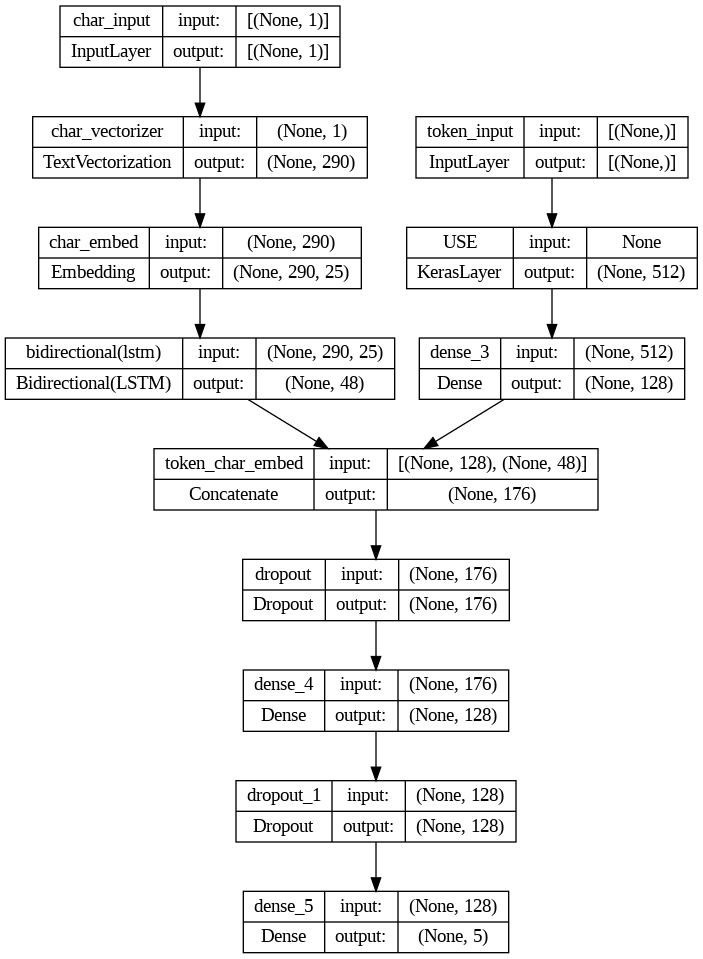

In [ ]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

##Creating a data pipeline of the tokenized and char level tokenized data

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

#prefetching and batching the data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

#prefetching and batching the data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                        epochs = 3,
                        validation_data=val_char_token_dataset,
                        validation_steps = int(0.1 * len(val_char_token_dataset)),
                        callbacks = [create_tensorboard_callback(SAVE_DIR, "Model_4_token_char_token")])

Saving TensorBoard log files to: model_logs/Model_4_token_char_token/20230710-133438
Epoch 1/3
562/562 [==============================] - 24s 32ms/step - loss: 0.9876 - accuracy: 0.6033 - val_loss: 0.7786 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.8080 - accuracy: 0.6874 - val_loss: 0.7197 - val_accuracy: 0.7224
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.7775 - accuracy: 0.7009 - val_loss: 0.6946 - val_accuracy: 0.7380


In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 16s 16ms/step


{'accuracy': 73.15636171057858,
 'precision': 0.7320962797367093,
 'recall': 0.7315636171057858,
 'f1': 0.7296596293928765}

##Model 5: Transfer learning with pretrained token embeddings + character emebeddings + positional embeddings

###Creating positional embeddings
The engineeered feasturs should be available during the runtime of the test data

In [ ]:
#How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

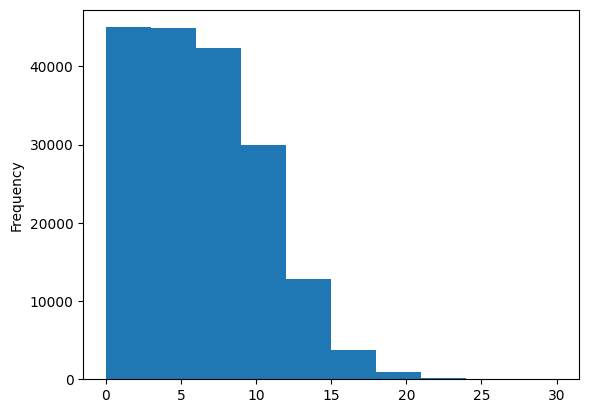

In [ ]:
#Checking the distribution of the lines numbers
train_df.line_number.plot.hist()

In [ ]:
#Using the tensorflow one hot encoading the line numbers
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [ ]:
train_line_number_one_hot.shape

TensorShape([180040, 15])

In [ ]:
#Finding th eline nujmbers need for toal lines in ana aabstract
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
#Finindg the number of lines nos to one hot encode
np.percentile(train_df.total_lines,98)

20.0

<Axes: >

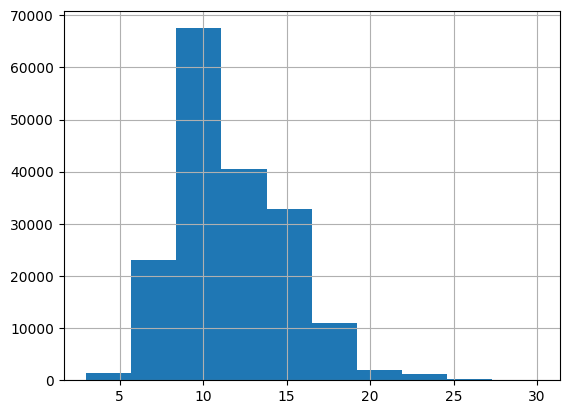

In [ ]:
train_df.total_lines.hist()

In [ ]:
#Encopading the total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [ ]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

###Creating the Tribrid model

In [ ]:
#1. token  inputs
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_layer")
token_embeddings = embed(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. character intputs
char_inputs = layers.Input(shape = [1,], dtype = "string", name = "character_tokenization_layer")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3.Line number embedding model
line_number_inputs = layers.Input(shape =[15, ], dtype = tf.int32, name = "Line_embedding")
line_number_outputs = layers.Dense(32, activation = "relu")(line_number_inputs)
line_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. total_lines embedding model
total_line_inputs = layers.Input(shape =[20, ], dtype = tf.int32, name = "Total_line_embedding")
total_line_outputs = layers.Dense(32, activation = "relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

#5.combining the outputs of 1 & 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embeddings")([token_model.output, char_model.output])

#6. adding dropout
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#7.combining the outputs from 4,3,& 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedings")([line_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

#8 Create output layer
final_dropout = layers.Dropout(0.5)(tribrid_embeddings)
output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(final_dropout)
model_5 = tf.keras.Model(inputs=[line_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer,
                         name="tribrid")

In [ ]:
#Fetching the model summary
model_5.summary()

Model: "tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_tokenization_layer (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 token_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_tokenization_layer[0]
 tion)                                                           [0]']                            
                                                                                            

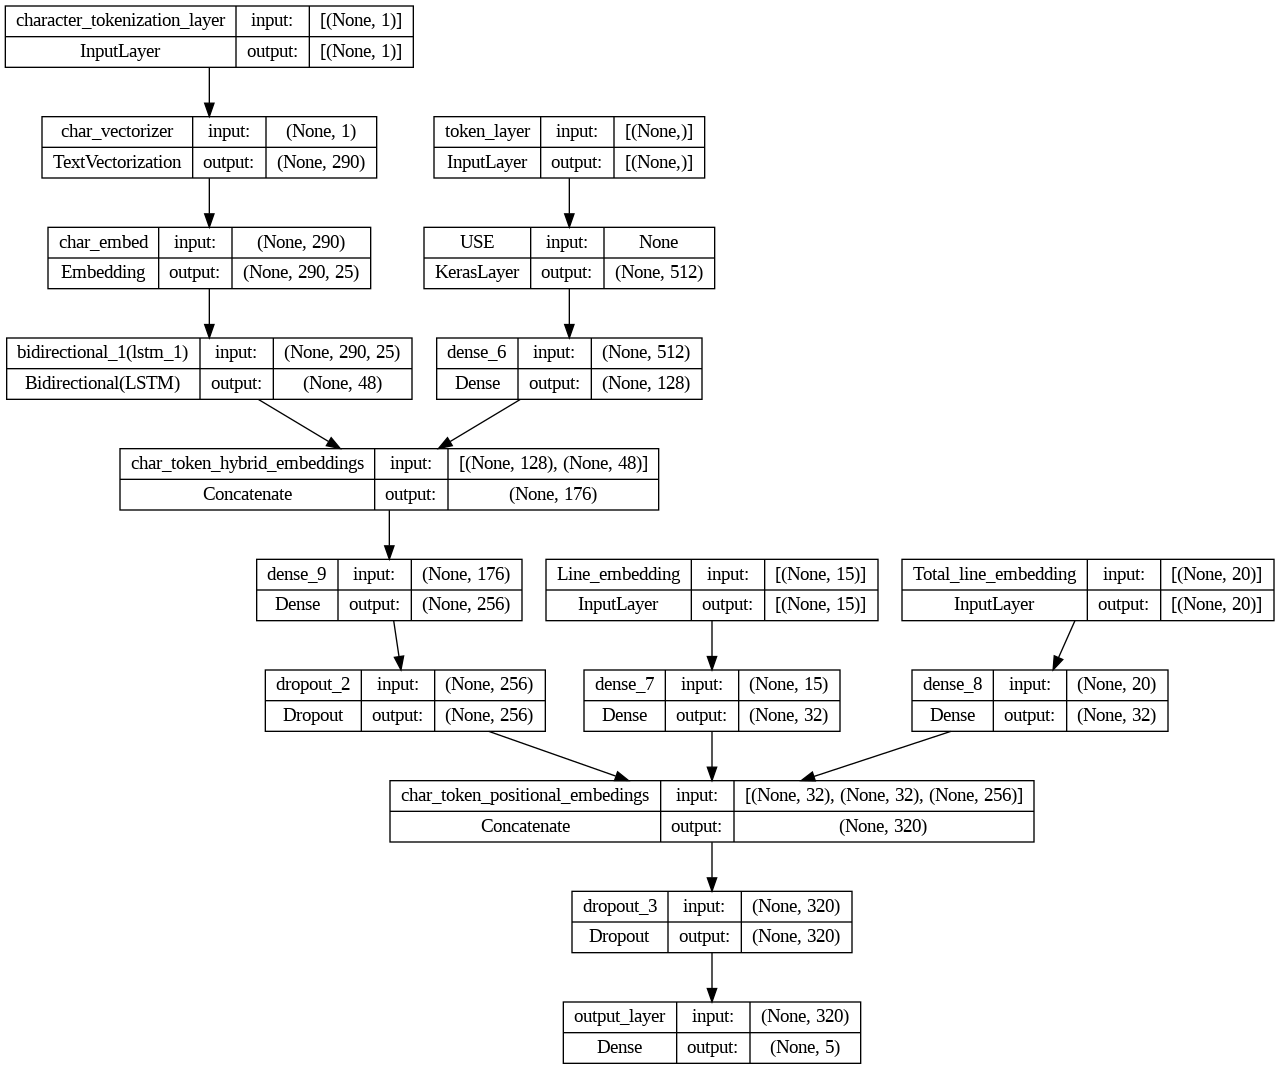

In [ ]:
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

###Creating data pipelines for line , total lines , token and character embeddings


In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_lines_one_hot ,train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

#prefetching and batching the data
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_lines_one_hot ,val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

#prefetching and batching the data
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

###Fitting the model

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,"model_5_tribrid")])

Saving TensorBoard log files to: model_logs/model_5_tribrid/20230710-133623
Epoch 1/3
562/562 [==============================] - 25s 33ms/step - loss: 1.1540 - accuracy: 0.6854 - val_loss: 1.0077 - val_accuracy: 0.7896
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 1.0131 - accuracy: 0.7924 - val_loss: 0.9637 - val_accuracy: 0.8178
Epoch 3/3
562/562 [==============================] - 16s 29ms/step - loss: 0.9963 - accuracy: 0.7993 - val_loss: 0.9528 - val_accuracy: 0.8265


In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.9502 - accuracy: 0.8241


[0.9501613974571228, 0.8241096138954163]

In [ ]:
from helper_functions import plot_loss_curves

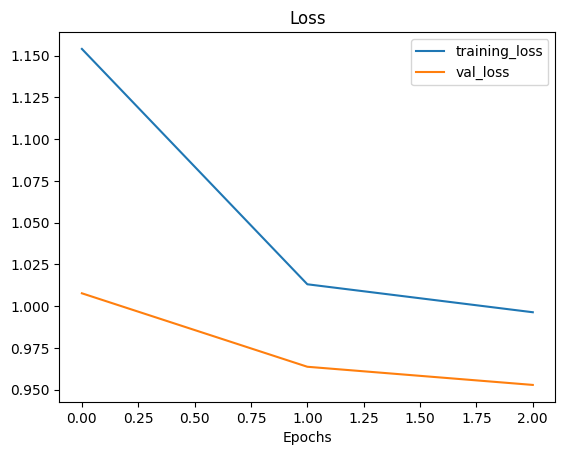

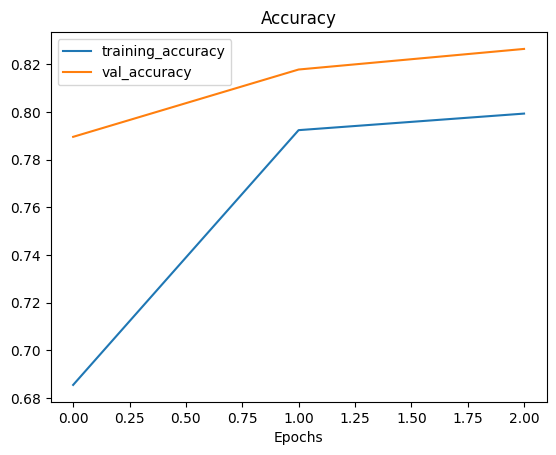

In [ ]:
plot_loss_curves(history_model_5)

In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 17s 17ms/step


array([[0.51879483, 0.10308579, 0.01507186, 0.34187627, 0.02117129],
       [0.51592785, 0.15217958, 0.04547675, 0.27260375, 0.01381209],
       [0.2983771 , 0.09230597, 0.1379962 , 0.40824562, 0.06307513],
       ...,
       [0.03199126, 0.10259528, 0.04578574, 0.0313599 , 0.78826785],
       [0.03617224, 0.29423034, 0.11969192, 0.0315776 , 0.5183279 ],
       [0.20247321, 0.46726766, 0.18905888, 0.05392459, 0.08727559]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.41096253144445,
 'precision': 0.8235668447255297,
 'recall': 0.8241096253144445,
 'f1': 0.8230086696412166}

##Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.087382,0.798378,0.800874,0.798462
pretrained_token_embed,71.345823,0.714027,0.713458,0.710652
custom_char_embed_conv1d,65.752019,0.656030,0.657520,0.645300
hybrid_char_token_embed,73.156362,0.732096,0.731564,0.729660
tribrid_pos_char_token_embed,82.410963,0.823567,0.824110,0.823009


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

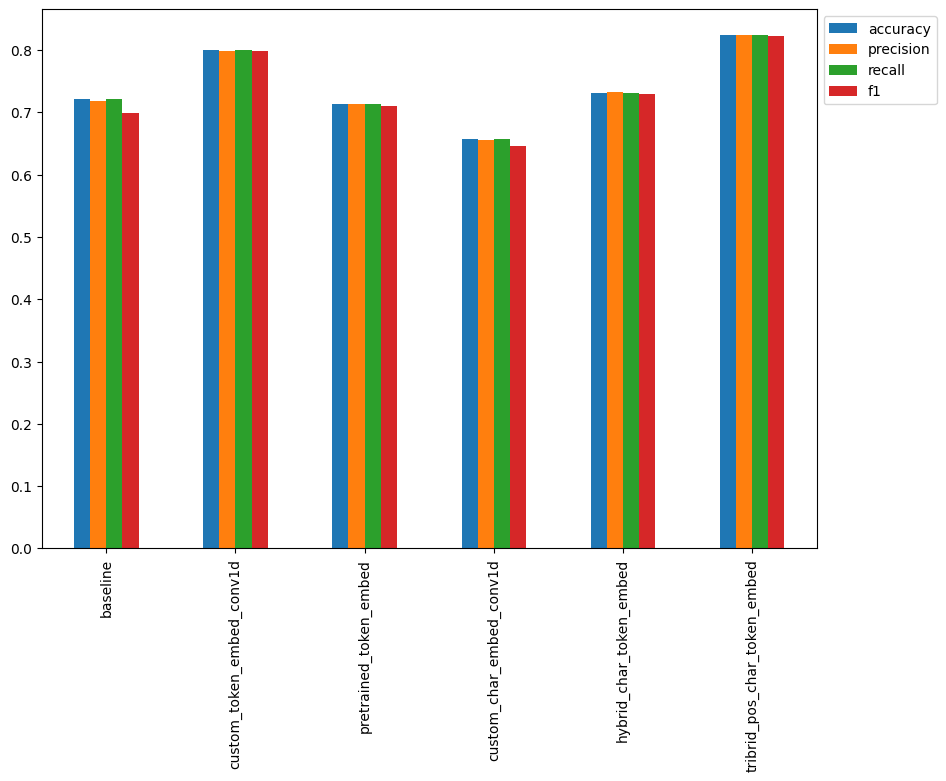

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

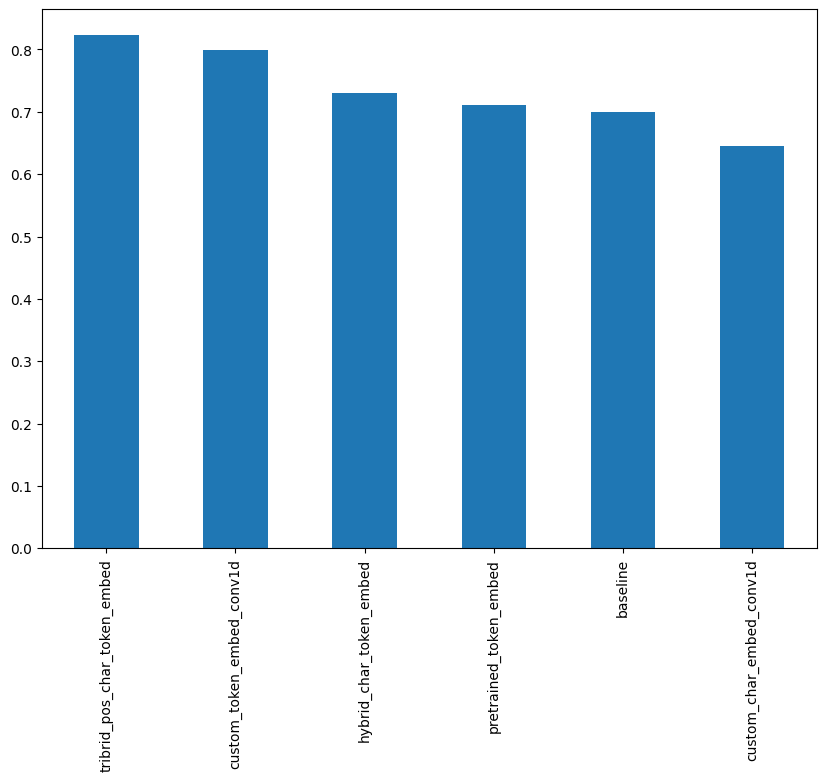

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# # View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# # Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "Research paper Skimmer" \
   --description "Comparing multiple different types of model architectures for selection of optimal model for skimming a medical reseasrch paper" \
   --one_shot # exit the uploader once uploading is finished

2023-07-10 11:41:43.116836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   XWV-MQC-VWB



New experiment created. View your TensorBoard at: https://tensorboard.dev/experi

**Tensorboard Link**
https://tensorboard.dev/experiment/ulX1DpmrSjmfpJmV0Iy8rw/#scalars&runSelectionState=eyJNb2RlbF80X3Rva2VuX2NoYXJfdG9rZW4vMjAyMzA3MTAtMDg0OTA1L3RyYWluIjp0cnVlLCJNb2RlbF81X3Rva2VuX2NoYXJfdG9rZW5fcG9zX2VtYmVkZGluZ3MvMjAyMzA3MTAtMTEwOTM5L3ZhbGlkYXRpb24iOmZhbHNlLCJNb2RlbF81X3Rva2VuX2NoYXJfdG9rZW5fcG9zX2VtYmVkZGluZ3MvMjAyMzA3MTAtMTEwOTM5L3RyYWluIjpmYWxzZSwiTW9kZWxfNV90b2tlbl9jaGFyX3Rva2VuX3Bvc19lbWJlZGRpbmdzLzIwMjMwNzEwLTExMDg0My90cmFpbiI6ZmFsc2UsIk1vZGVsXzVfdG9rZW5fY2hhcl90b2tlbl9wb3NfZW1iZWRkaW5ncy8yMDIzMDcxMC0xMTA3MDAvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzVfdG9rZW5fY2hhcl90b2tlbl9wb3NfZW1iZWRkaW5ncy8yMDIzMDcxMC0xMTA3MDAvdHJhaW4iOmZhbHNlfQ%3D%3D


In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

#loading the best model

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "/content/skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding


In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]


945/945 [==============================] - 20s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 84.45319740500463,
 'precision': 0.8439693854850434,
 'recall': 0.8445319740500463,
 'f1': 0.8434093109267011}

##Test data predictions



In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:

# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.0650406504065,
 'precision': 0.8394405724037995,
 'recall': 0.8406504065040651,
 'f1': 0.8394646027050884}

#Finding and visualizing the wrong predictions

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 18 s, sys: 763 ms, total: 18.7 s
Wall time: 18.8 s


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RES

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.483850,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.318997,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.827454,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.661504,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.706911,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.829595,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.632489,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.616158,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.577325,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.536445,True


In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.957163,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.937243,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.930989,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928728,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.926836,False
...,...,...,...,...,...,...,...
418,METHODS,this study provides class i evidence that for ...,10,10,CONCLUSIONS,0.828723,False
12458,RESULTS,home monitoring patients were assessed remotel...,3,13,METHODS,0.828473,False
2755,CONCLUSIONS,"overall , the intervention enhanced health at ...",6,8,RESULTS,0.828465,False
18526,RESULTS,clinicians expressed confidence in supervised ...,9,11,CONCLUSIONS,0.827791,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9571634531021118, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9372429251670837, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9309887290000916, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.928728461265564, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.926836371421814, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.926572859287262, Line number: 15, Total lines: 15

Text:
-lsb- netherlands trial register ( http://www.trialregister.nl/tr

##Making predictions on new data

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-07-10 11:57:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-10 11:57:06 (56.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 2.5 s, sys: 8.22 ms, total: 2.51 s
Wall time: 2.66 s


array([[0.3109735 , 0.08891147, 0.04309176, 0.5182437 , 0.0387796 ],
       [0.08130533, 0.02776471, 0.7257292 , 0.10901362, 0.05618718],
       [0.1093434 , 0.04931116, 0.60393804, 0.12225047, 0.11515688],
       [0.17696232, 0.20848903, 0.38255158, 0.10772789, 0.12426914],
       [0.05485379, 0.10669456, 0.28211308, 0.05668311, 0.4996555 ],
       [0.03647983, 0.0891163 , 0.43325976, 0.05498939, 0.38615474],
       [0.02737427, 0.14789686, 0.0539068 , 0.02842966, 0.7423924 ],
       [0.01990481, 0.11922593, 0.18249702, 0.03140947, 0.64696276]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


###Functionnizing the Prediction
Input: Takes in a medical abstract data in the form of a string

In [ ]:
#Functionnizing the data formatter and predictions
def prediction_abstract(abstract):
  # Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
  from spacy.lang.en import English
  nlp = English() # setup English sentence parser

  # New version of spaCy
  sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

  # Create "doc" of parsed sequences, change index for a different abstract
  doc = nlp(abstract)
  abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
  # Get all line_number values from sample abstract
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
  # Get all total_lines values from sample abstract
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
  # Split abstract lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
  test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
  # Turn prediction probabilities into prediction classes
  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
  # Turn prediction class integers into string class names
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
   #Visualize abstract lines and predicted sequence labels
  for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

In [ ]:
abs = "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."
prediction_abstract(abs)

1/1 [==============================] - 0s 62ms/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored 